In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import networkx as nx
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import math

def noise_variance(n:int, d:int, p:float) -> float:
    """
    Function that is injected as the noise parameter
    :param n: 
    :param d: 
    :param p: 
    :return: 
    """
    return (np.log(n) * d / n / math.sqrt(2) / math.sqrt(p))**2

def format_edges(weight) -> str:
    """
    simple str util
    :param weight: 
    :return: 
    """
    if weight<0.03:
        return ""
    else:
        return f"{weight:.3f}"

def single_mi(x, y, bins) -> float:
    """
    Calculates the mutual information of two data rows (columns)
    :param x: 
    :param y: 
    :param bins: 
    :return: 
    """
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def generate_mi(ds):
    """
    Generates mutual information matrix. "might" be inefficient for large values
    :param ds: 
    :return: 
    """
    n = ds.shape[1]
    mi_gen = np.zeros((n, n))
    
    ## todo make lambda
    for ix in np.arange(n):
        for jx in np.arange(ix, n):
            print(f'Working on column: {ix}/{jx}')
            mi_gen[ix,jx]= single_mi(dataset.iloc[:, ix].values, dataset.iloc[:, jx].values, 10)
            mi_gen[jx, ix] = mi_gen[ix, jx] # Preserving Symmetry
    return mi_gen


def mst(mutual_information, G=None):
    """
    Enables calculating a spanning tree using the networkX library
    :param mutual_information: 
    :return: 
    """
    G = nx.from_numpy_array(mutual_information.copy()) if G is None else G
    
    print(f'The Graph {G}')
    T = nx.maximum_spanning_tree(G, algorithm='prim')
    return (G,  ## Graph
            T, ## Spanning Tree
            sum (d['weight'] for _,_,d in T.edges(data=True)) ## Weight on this one. 
            )
    
def private_mst(mi, amount_noise):
    """
    Adds noise to mutual information, generates a spanning tree and then transfers back to the original edges
    :param mi: 
    :param amount_noise: 
    :return: 
    """
    print(f'Dimensions: {d} and datapoints: {n}')
    mi_noisy= np.add(mi, np.random.normal(0, amount_noise, size=(d,d))) ## Adds noise
    print(mi_noisy)
    G = nx.from_numpy_array(mutual_information.copy())
    
    print(np.subtract(mi_noisy, mi))
    (_, T, mst_weight) = mst(mi_noisy) 
    print(sum_weights(G,T)) # why negative?
    return G, T, sum_weights(G, T)  # Maps the new weight to the original ones

def sum_weights(original_graph, spanning_tree) -> float:
    """
   Takes a graph and a set of edges and calculates the weight.
   
   Can be used to return the weight of a spanning tree for given edges
    :param original_graph: 
    :param spanning_tree: 
    :return:  
    """
    return sum(
        original_graph[e[0]][e[1]]['weight']
        for e in spanning_tree.edges()
    )
def load_ds(extracted_dims:int):
    ds=pd.read_csv("./datasets/retail.dat.txt",
                   header=0,
                   delim_whitespace=True,
                   on_bad_lines='skip',
                   dtype='Int64'
                   )
    print("Finished Loading dataset")
    
    feature_vector_ds = pd.DataFrame(columns=range(extracted_dims))
    feature_vector_ds.reset_index(drop=True)
    # row = pd.DataFrame(0, index=[1], columns=range(extracted_dims))
    
    rows = []
    for idx, r in ds.iterrows():
        row = [0] * extracted_dims
        for el in r:
            if pd.isna(el) or el >= extracted_dims: continue # little data cleaning
            if el >= extracted_dims: break
            row[el] = 1
        rows.append(row)
    feature_vector_ds = pd.DataFrame.from_records(rows)
    feature_vector_ds.columns = range(extracted_dims)
    
    print(f'Finished loading dataset with {extracted_dims} dimensions and {len(ds)} rows')
    print(ds.head())
    return extracted_dims, len(ds), feature_vector_ds

In [ ]:
## Assuming binary dataset with sensitivity d log n / n

d = 20 # num dims
p = 0.01 # zCDP
n = 1000 # num samples
mu  = 0.0001
# probabilty to stay outside the bound of a max error.

## With probability 1 - m, error is not larger as the bound
numDS = 1000
values = np.random.normal(0, (d**2 * np.log(n)**2) / (2 * p * n**2), size=(numDS, d*d))
a = [max(abs(x), key=abs) for x in values] # max error

# printing max error per round
plot = sb.histplot(a)
sigma = (d * np.log(n) / n / np.sqrt(2 * p))
threshold =  (sigma) * np.sqrt(np.log(d / mu))
print(threshold)

plot.axvline(x = threshold,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1) # Top of the plot

In [8]:
# Load Data
columns = [3,6,7,8,9,10,11,17,24]

# Old dataset.
# dataset=pd.read_csv("./datasets/Surgical-deepnet.csv", header=0, usecols=columns, index_col=0)



Finished Loading
Finished loading dataset with 20 dimensions and 85548 rows
   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  \
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

   19  
0   0  
1   0  
2   0  
3   0  
4   0  


MST on Real Graph 0.20138706906229925


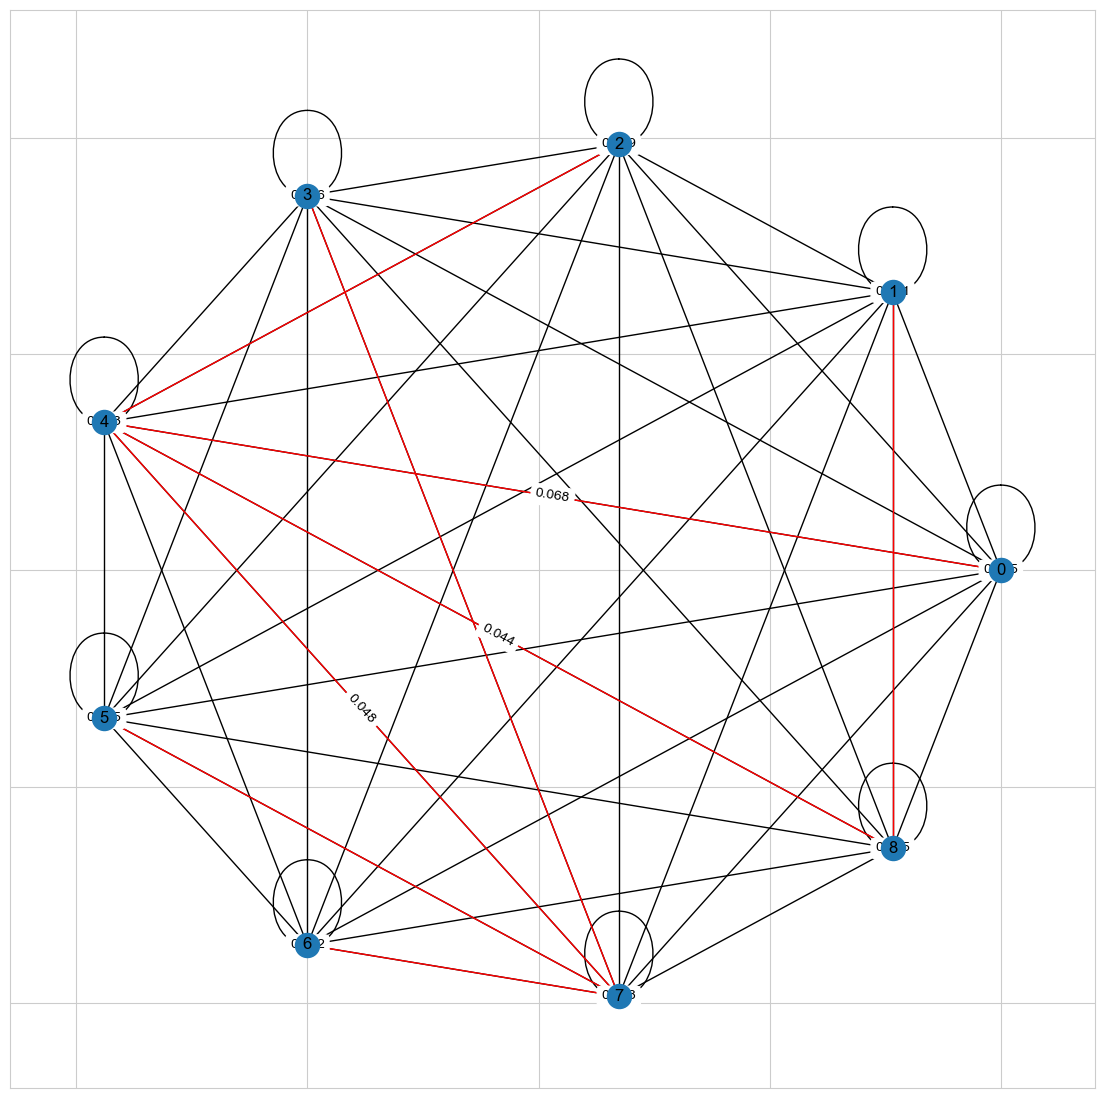

In [21]:
## Step 1: real MST

mutual_information = generate_mi(dataset)
G = nx.from_numpy_array(mutual_information)
G = nx.convert_node_labels_to_integers(G)
T= nx.maximum_spanning_tree(G, algorithm ='prim')

# Calculating the Real weight
weight = 0
for _,_,d in T.edges(data=True):
    weight += d['weight']
print(f'MST on Real Graph {weight}')

plt.figure(3,figsize=(14,14))
pos = nx.circular_layout(G, scale=40)  # positions for all nodes - seed for reproducibility

nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edges(T, pos, edge_color="red")
nx.draw_networkx_labels(G, pos)
# edge weight labels
edge_labels = dict([((u,v,), format_edges(d['weight'])) for u,v,d in G.edges(data=True)])

nx.draw_networkx_edge_labels(G, pos, edge_labels)
# larger figure size
plt.show()

We have 14635 samples on 9 dimensions
MST on Real Graph 0.20138706906229925
MST on Fake Graph 0.2161310732983846


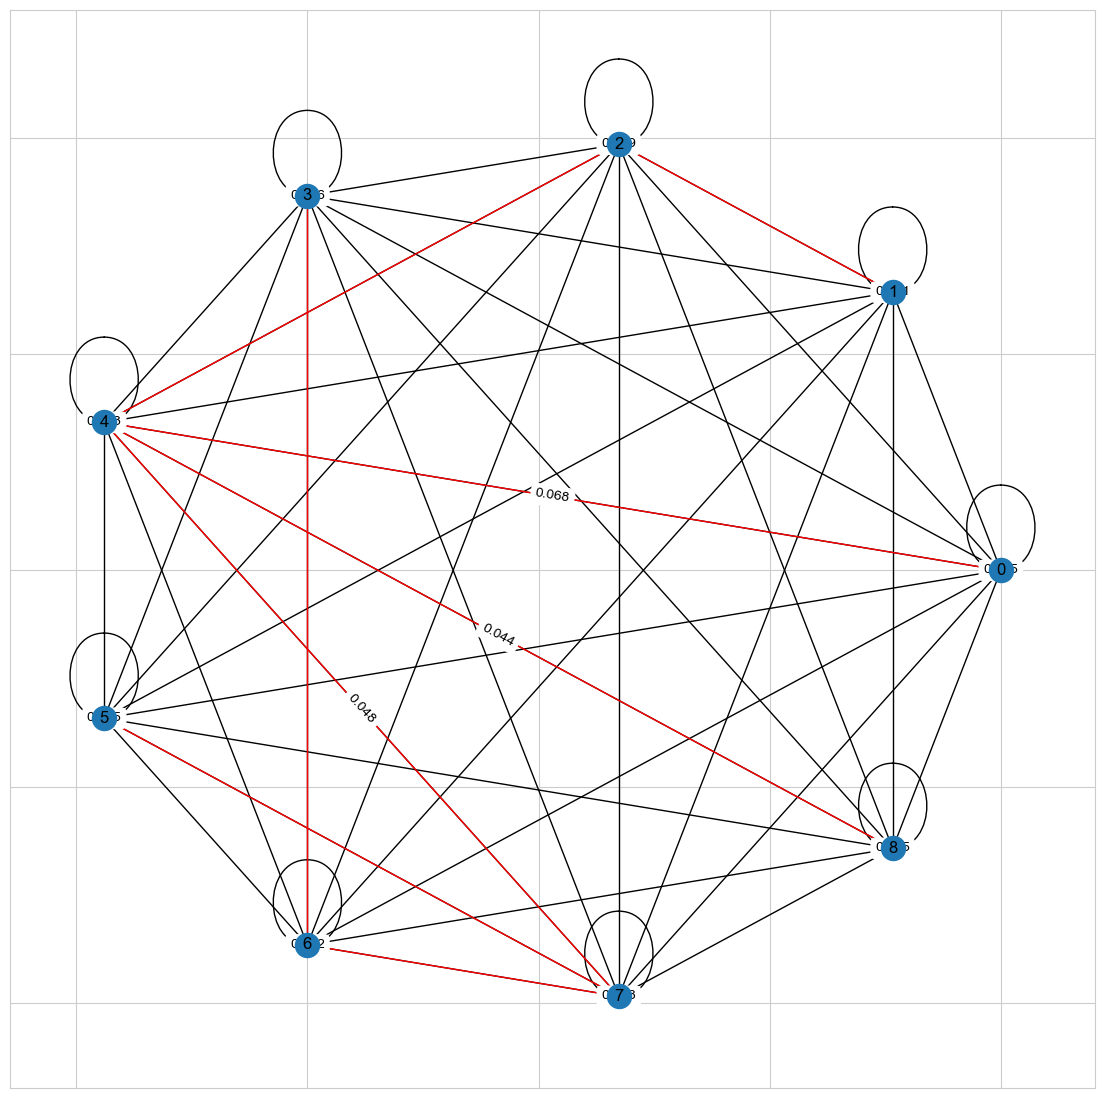

In [22]:
# Step 2: Noisy MST
   
p = 1 # privacy rho
d = len(columns)

(T1, private_weight) = private_mst(p, dataset)
(spanning_tree, real_weight) = private_mst(p, dataset, priv=False)
G = nx.convert_node_labels_to_integers(G)

# Calculating the Real weight
print(f'We have {n} samples on {d} dimensions')
print(f'MST on Real Graph {real_weight}')
print(f'MST on Fake Graph {private_weight}')

plt.figure(3,figsize=(14,14))
pos = nx.circular_layout(G, scale=40)  # positions for all nodes - seed for reproducibility

nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edges(T1, pos, edge_color="red")
nx.draw_networkx_labels(G, pos)
# edge weight labels
edge_labels = dict([((u,v,), format_edges(d['weight'])) for u,v,d in G.edges(data=True)])

nx.draw_networkx_edge_labels(G, pos, edge_labels)
# larger figure size
plt.show()

Finished Loading dataset
Finished loading dataset with 20 dimensions and 85548 rows
    0   1   2     3     4     5     6     7     8     9  ...    20    21  \
0  30  31  32  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  ...  <NA>  <NA>   
1  33  34  35  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  ...  <NA>  <NA>   
2  36  37  38    39    40    41    42    43    44    45  ...  <NA>  <NA>   
3  38  39  47    48  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  ...  <NA>  <NA>   
4  38  39  48    49    50    51    52    53    54    55  ...  <NA>  <NA>   

     22    23    24    25    26    27    28    29  
0  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  
1  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  
2  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  
3  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  
4  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  

[5 rows x 30 columns]
Starting with n=85548 and d=20
Working on column: 0/0
Working on column: 0/1
Working on column: 0/2
Working on column: 0/3
W

/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_20937/2238233052.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_series = p_series.append(row, ignore_index=True)
/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_20937/2238233052.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_series = p_series.append(row, ignore_index=True)
/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_20937/2238233052.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_series = p_series.append(row, ignore_index=True)
/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_20937/2238233052.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

[[ 1.26228586e-02  3.05123854e-05  4.78886645e-05  3.57640268e-06
  -1.08824583e-05  1.00255552e-04 -4.32982886e-05  1.12857001e-04
  -2.77291932e-05  4.60753179e-05  1.31409078e-04  1.46907080e-05
   1.23430462e-06 -9.36674704e-06 -4.79028390e-05 -1.39982584e-05
   3.62426178e-05 -3.92736976e-06  3.74269566e-05  4.97294129e-05]
 [-7.73469008e-06  1.99160400e-02 -1.97158262e-05 -8.29373037e-05
   4.82681486e-05 -3.63186178e-05  7.91104404e-05  1.25817210e-04
  -4.22438735e-05 -3.91962724e-05  5.43194605e-05 -1.66937463e-05
  -4.90779730e-05  3.69327396e-05 -2.59627942e-05 -1.15555266e-04
  -1.82431375e-05 -5.78768614e-05 -5.85501046e-05  9.64350218e-05]
 [ 8.37172554e-05  1.39751748e-05  3.59836770e-02 -4.82240014e-05
  -5.51854854e-05 -9.09061862e-05  1.99927293e-05  3.08989193e-05
   1.06608626e-04  7.96964359e-06  3.33726983e-05 -1.35033523e-05
   7.46776628e-05  6.50458744e-05  1.85415826e-05 -8.37934183e-06
   3.43965264e-06  2.42874248e-05  4.53371054e-05 -7.04691344e-05]
 [-7.33

/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_20937/2238233052.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_series = p_series.append(row, ignore_index=True)
/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_20937/2238233052.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_series = p_series.append(row, ignore_index=True)
/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_20937/2238233052.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_series = p_series.append(row, ignore_index=True)
/var/folders/sr/cj3fzqgj79572q295vk3yxw00000gn/T/ipykernel_20937/2238233052.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

[[ 1.26582962e-02  4.00232253e-05  1.09256699e-05 -1.52778946e-06
  -3.25772948e-06  1.56316011e-04  5.59765338e-06  3.84821074e-05
  -1.09987099e-06  2.76698475e-05  1.03345762e-05  1.41857319e-05
   2.43003122e-05 -1.29194875e-06  2.17123093e-06 -1.21855700e-06
   6.21618505e-05 -2.47181898e-06  3.31977051e-07  2.96345853e-06]
 [ 4.19246241e-05  1.99093454e-02  4.75279803e-06 -3.66196126e-06
  -4.95311980e-06  7.59208915e-06  5.79956367e-06  8.91881296e-05
  -5.01361775e-06  1.71879911e-05  6.88878911e-05  5.48487660e-05
   1.51967359e-05 -1.57028873e-06  2.54073856e-05 -7.39838419e-07
   7.39900492e-05  2.92754834e-06  6.71748324e-06  4.77683159e-05]
 [ 8.89295633e-07  6.95882927e-06  3.60627363e-02  2.85629472e-06
   4.10483205e-06  2.22166788e-06  1.03983737e-05 -1.85342822e-07
   5.68817412e-06  3.99622639e-07 -3.26334870e-06  9.71397432e-06
  -1.06497450e-05  1.82533345e-05  1.82893391e-05  8.95723299e-06
   3.93605615e-06  1.07190342e-05  3.30796907e-05  8.20136964e-06]
 [ 2.84

<Axes: xlabel='p', ylabel='value'>

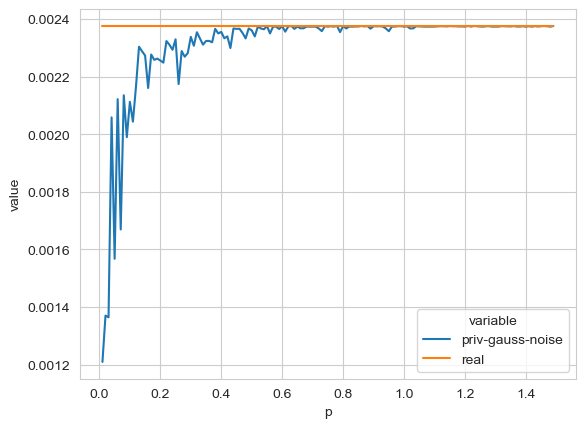

In [3]:
p_series = pd.DataFrame()
(d, n, dataset) = load_ds(20)

# Metaparams
RHO_UP = 1.5
RHO_LOW = 0.01
STEP = 0.01

print(f'Starting with n={n} and d={d}')
mutual_information = generate_mi(dataset)
(G, spanning_tree, real_weight) = mst(mutual_information[:])
print(spanning_tree)
for p in np.arange(RHO_LOW,RHO_UP, STEP):
    noise = noise_variance(n, d, p)
    (G, T1, private_weight) = private_mst(mi=mutual_information[:], amount_noise=noise)
    row = {
        "p": p,
        "priv-gauss-noise": private_weight, 
        "real": real_weight}
    p_series = p_series.append(row, ignore_index=True)

print(f'We have {len(dataset)} samples on {d} dimensions')
print(f'MST on Real Graph {real_weight}')
print(f'MST on Fake Graph {private_weight}')
sb.lineplot(x='p', y='value', hue='variable',
            data=pd.melt(p_series, ['p']))



In [ ]:
spanning_tree.edges()

We have -1 samples on -1 dimensions
MST on Real Graph 0.0023757128138483636
MST on Fake Graph 0.08203354189144658


<Axes: xlabel='p', ylabel='value'>

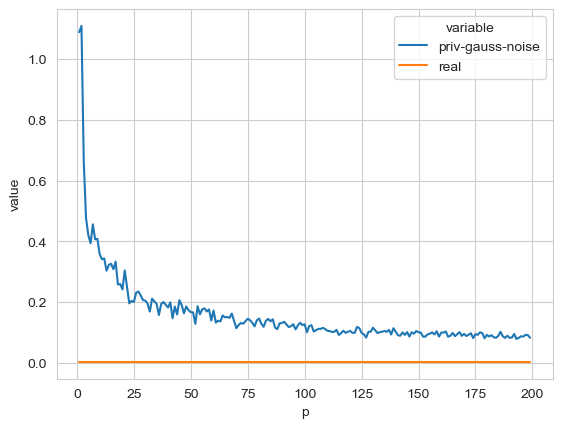